In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

Populating the interactive namespace from numpy and matplotlib


/home/alex/anaconda3/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
t = pd.read_csv("multiTimeline.csv",sep=',',index_col=['Месяц'], parse_dates=['Месяц'])

In [3]:
t

,анализ данных:
Месяц,
2004-01-01,39
2004-02-01,51
2004-03-01,79
2004-04-01,0
2004-05-01,21
2004-06-01,42
2004-07-01,22
2004-08-01,0
2004-09-01,19


In [7]:
t.columns=['Dataanalysis']

In [10]:
t['Dataanalysis1'] = t.Dataanalysis[:]+1

In [11]:
t.head()

,Dataanalysis,Dataanalysis1
Месяц,,
2004-01-01,39,40
2004-02-01,51,52
2004-03-01,79,80
2004-04-01,0,1
2004-05-01,21,22


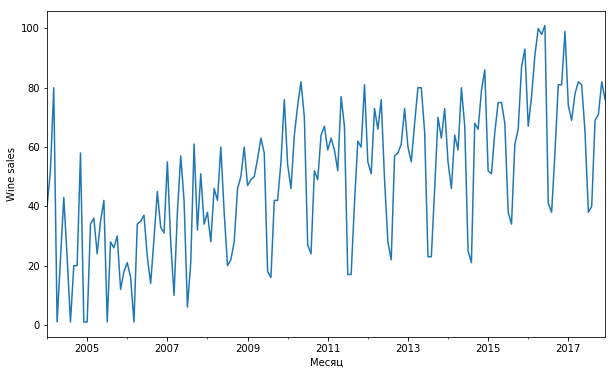

In [6]:

figsize(10,6)
t.Dataanalysis1.plot()
plt.ylabel('Wine sales')
pylab.show()

Критерий Дики-Фуллера: p=0.795403


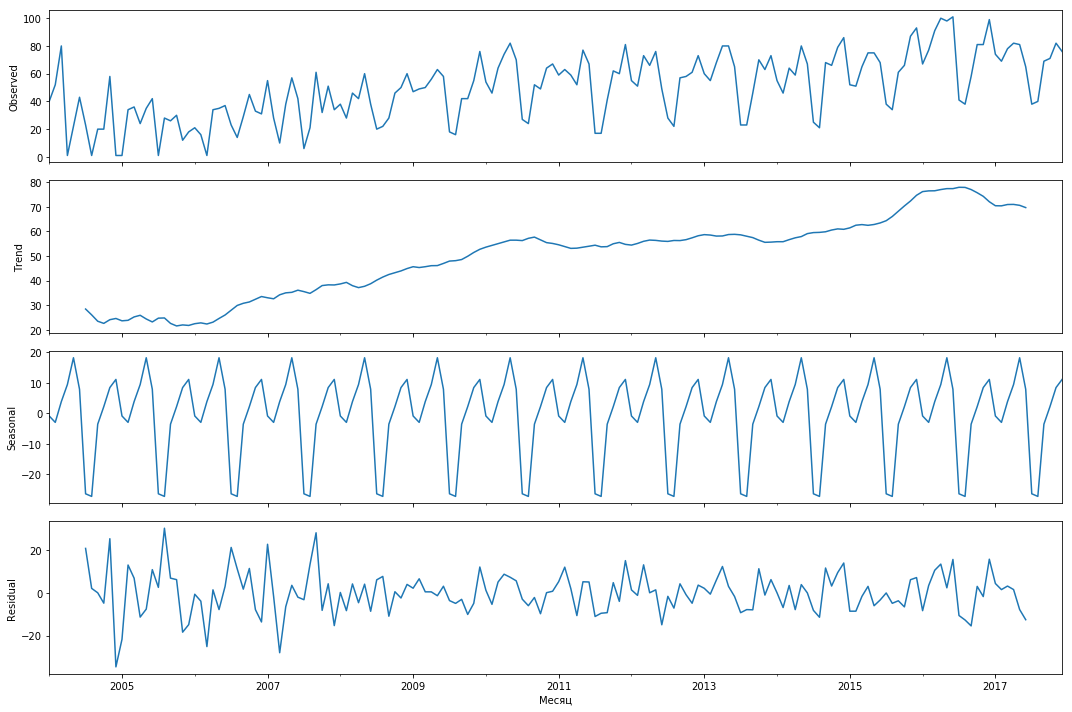

In [7]:
figsize(15,10)
sm.tsa.seasonal_decompose(t.Dataanalysis1).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(t.Dataanalysis1)[1])

Оптимальный параметр преобразования Бокса-Кокса: 0.886935
Критерий Дики-Фуллера: p=0.763606


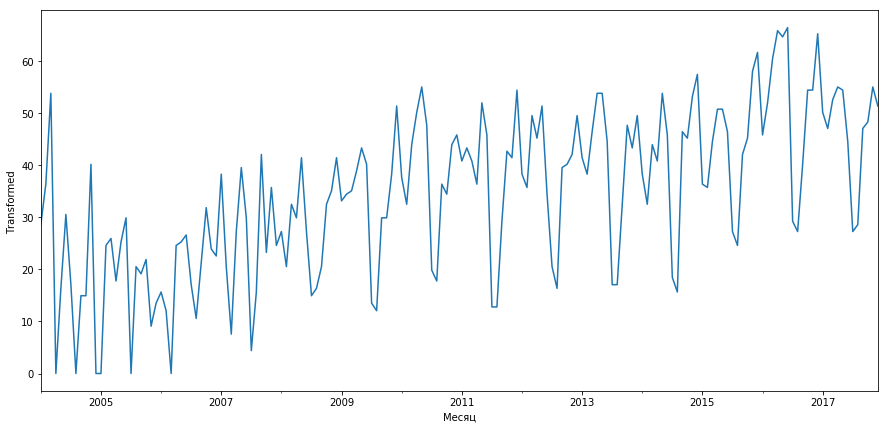

In [8]:
t['Dataanalysis1_box'], lmbda = stats.boxcox(t.Dataanalysis1)
figsize(15,7)
t.Dataanalysis1_box.plot()
plt.ylabel(u'Transformed ')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(t.Dataanalysis1_box)[1])

Критерий Дики-Фуллера: p=0.001860


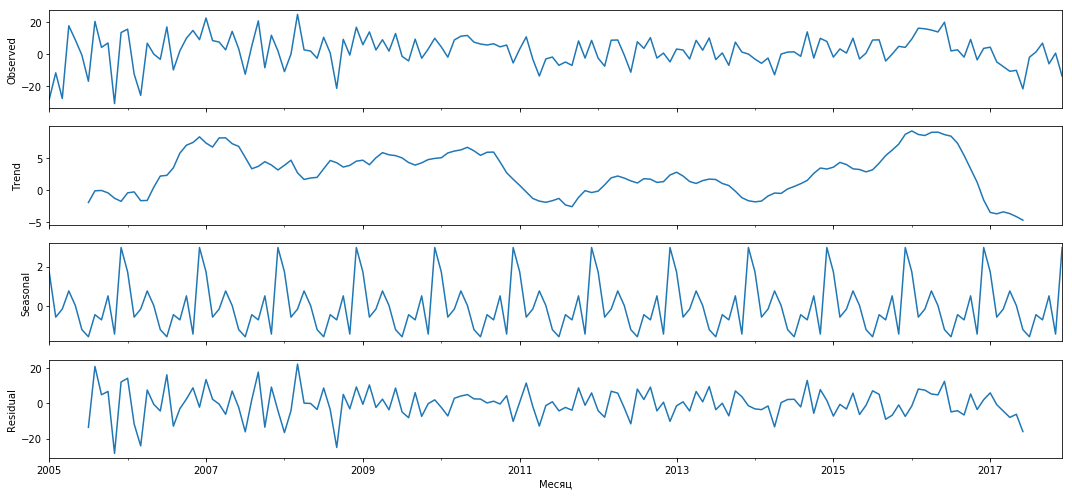

In [9]:
t['Dataanalysis1_box_diff'] = t.Dataanalysis1_box - t.Dataanalysis1_box.shift(12)
sm.tsa.seasonal_decompose(t.Dataanalysis1_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(t.Dataanalysis1_box_diff[12:])[1])

Критерий Дики-Фуллера: p=0.000009


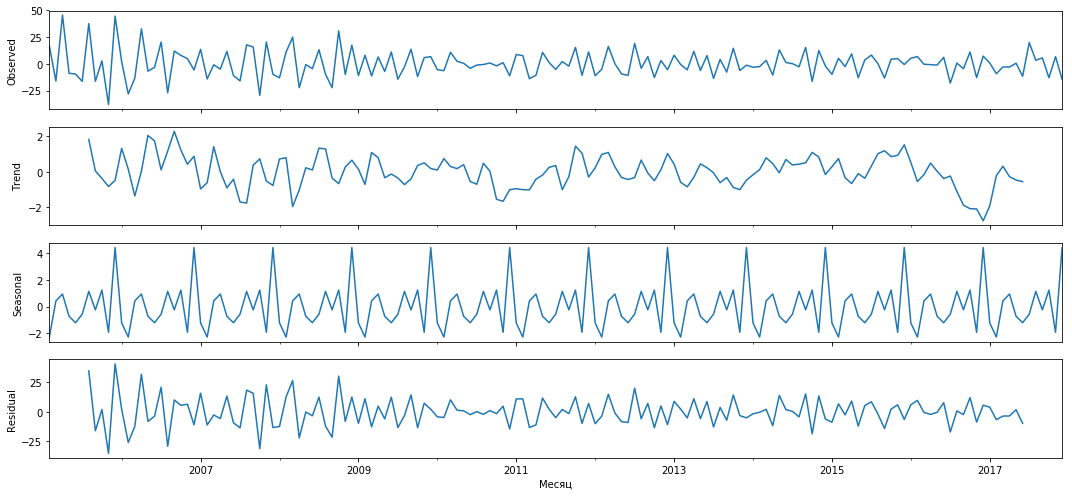

In [10]:
t['Dataanalysis1_box_diff2'] = t.Dataanalysis1_box_diff - t.Dataanalysis1_box_diff.shift(1)
sm.tsa.seasonal_decompose(t.Dataanalysis1_box_diff2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(t.Dataanalysis1_box_diff2[13:])[1])

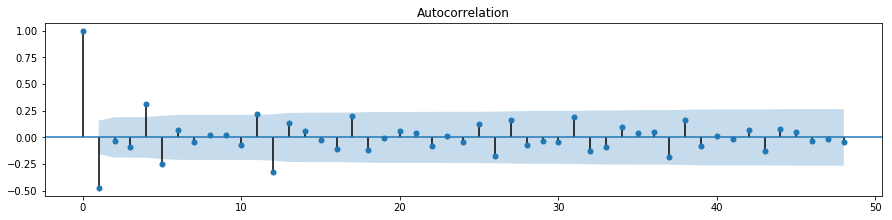

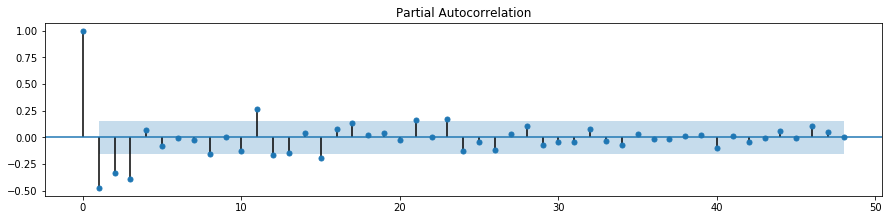

In [11]:
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(t.Dataanalysis1_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(t.Dataanalysis1_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Начальные приближения: Q=1, q=3, P=1, p=5

In [13]:
ps = range(0, 6)
d=1
qs = range(0, 4)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

In [14]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

96

In [15]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(t.Dataanalysis1_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (0, 0, 0, 0)
wrong parameters: (2, 1, 0, 0)
wrong parameters: (2, 1, 0, 1)
wrong parameters: (2, 1, 1, 0)
wrong parameters: (2, 1, 1, 1)
wrong parameters: (4, 2, 0, 0)
wrong parameters: (4, 2, 0, 1)
wrong parameters: (4, 2, 1, 0)
wrong parameters: (4, 2, 1, 1)
wrong parameters: (4, 3, 0, 0)
wrong parameters: (4, 3, 0, 1)
wrong parameters: (4, 3, 1, 0)
wrong parameters: (4, 3, 1, 1)
wrong parameters: (5, 3, 0, 0)
wrong parameters: (5, 3, 0, 1)
wrong parameters: (5, 3, 1, 0)
wrong parameters: (5, 3, 1, 1)
Wall time: 1min 3s


In [16]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters          aic
64  (4, 1, 0, 1)  1122.389847
56  (3, 3, 0, 1)  1122.621537
72  (5, 1, 0, 1)  1122.789365
66  (4, 1, 1, 1)  1123.711497
58  (3, 3, 1, 1)  1123.794587


In [17]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                  Dataanalysis1_box   No. Observations:                  168
Model:             SARIMAX(4, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -554.195
Date:                            Wed, 13 Dec 2017   AIC                           1122.390
Time:                                    21:59:06   BIC                           1144.258
Sample:                                01-01-2004   HQIC                          1131.265
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1706      0.074      2.303      0.021       0.025       0.316
ar.L2          0.0137      0.092   

Критерий Стьюдента: p=0.077849
Критерий Дики-Фуллера: p=0.000000


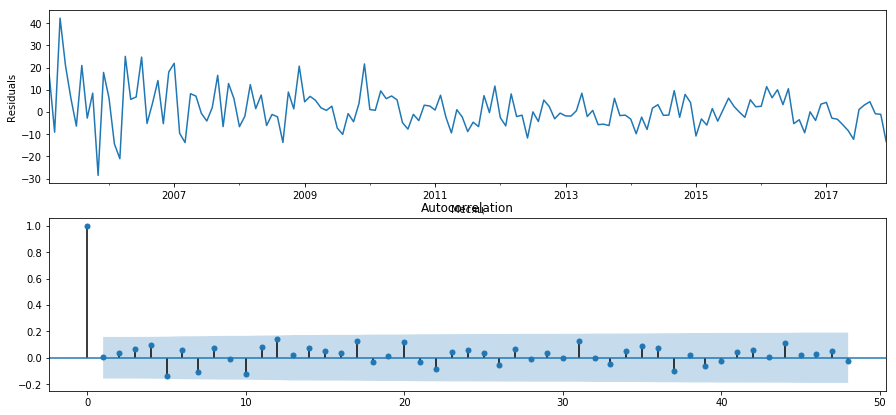

In [18]:
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой). Посмотрим, насколько хорошо модель описывает данные:

In [19]:

def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  


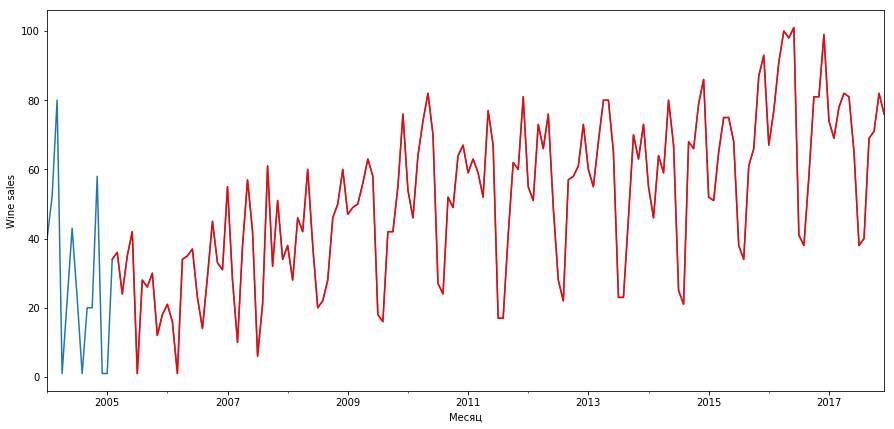

In [20]:
t['model'] = invboxcox(best_model.fittedvalues, lmbda)
t.Dataanalysis1.plot()
t.Dataanalysis1[13:].plot(color='r')
plt.ylabel('Wine sales')
pylab.show()

In [23]:
type(t.Dataanalysis1)

pandas.core.series.Series

In [29]:
Dataanalysis2 =t['Dataanalysis']+1


In [31]:
type(Dataanalysis2)

pandas.core.series.Series

In [37]:
wine2 = t['Dataanalysis3']
date_list = [datetime.datetime.strptime("2017-12-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= wine2.columns)
wine2 = pd.concat([wine2, future])
wine2['forecast'] = invboxcox(best_model.predict(start=171, end=223), lmbda)

plt.figure(figsize(15,7))
wine2.sales.plot()
wine2.forecast.plot(color='r')
plt.ylabel('Wine sales')
pylab.show()

KeyError: 'Dataanalysis3'